In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek, SMOTEENN
# SMOTEENN both oversamples the minority and cleans borderline/noisy examples, often yielding better generalization than plain SMOTE.
import warnings
from datetime import datetime

# Record start time
start_time = datetime.now()

# Suppress warnings
warnings.filterwarnings('ignore')

# Constants
RANDOM_STATE = 42

# Severity level mapping
SEVERITY_MAPPING = {
    'Property damage below reporting threshold': 0,
    'Property damage only': 1,
    'Minor': 2,
    'Serious': 3,
    'Fatal': 4
}

# Load data
print("Loading data...")
data = pd.read_csv('C:/Users/fairt/OneDrive/Desktop/collision1.csv')

# Drop datetime and unnecessary columns
columns_to_drop = ['Acc_Date', 'Weekday', 'Month', 'Year', 'Unnamed: 0']
data = data.drop(columns=columns_to_drop)

print("\nChecking for NaN values before processing:")
print(data.isnull().sum())

# Handle NaN values in Severity column
if data['Severity'].isnull().any():
    print("\nRemoving rows with NaN values in Severity column...")
    data = data.dropna(subset=['Severity'])

# Separate features and target
X = data.drop('Severity', axis=1)
y = data['Severity'].map(SEVERITY_MAPPING)

# Convert categorical columns to numeric
print("\nEncoding categorical variables...")
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column].astype(str))
    print(f"Encoded {column}: {len(label_encoders[column].classes_)} unique values")

# Standardize the features
# SMOTE works best on data without wildly different scales.
print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Print original data statistics
print(f"\nOriginal data shape: {X_scaled.shape}")

# Original class distribution
print("\nOriginal class distribution:")
orig_dist = pd.Series(y).value_counts().sort_index()
print(orig_dist)

print("\nOriginal class distribution percentages:")
orig_dist_pct = (orig_dist / len(y) * 100).round(2)
print(orig_dist_pct.astype(str) + ' %')

# Calculate original imbalance metrics
print("\nOriginal imbalance metrics:")
print(f"Imbalance ratio: {orig_dist.max() / orig_dist.min():.2f}")
print(f"Standard deviation of class sizes: {orig_dist.std():.2f}")

# Apply SMOTEENN
print("\nApplying SMOTEENN...")
smote_enn = SMOTEENN(random_state=RANDOM_STATE, n_jobs=-1)
#smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Print resampled data statistics
print(f"\nResampled data shape: {X_resampled.shape}")

# Resampled class distribution
print("\nClass distribution after SMOTEENN:")
resampled_dist = pd.Series(y_resampled).value_counts().sort_index()
print(resampled_dist)

# Calculate resampled imbalance metrics
print("\nResampled imbalance metrics:")
print(f"Imbalance ratio: {resampled_dist.max() / resampled_dist.min():.2f}")
print(f"Standard deviation of class sizes: {resampled_dist.std():.2f}")

# Inverse transform the standardized features
# inverse‐transform after resampling so that the downstream analyses stay interpretable
X_resampled_original_scale = scaler.inverse_transform(X_resampled)
X_resampled_original_scale = pd.DataFrame(X_resampled_original_scale, columns=X.columns)

# Create resampled dataframe
resampled_df = pd.DataFrame(X_resampled_original_scale, columns=X.columns)
resampled_df['Severity'] = y_resampled

# Save to CSV
resampled_df.to_csv('C:/Users/fairt/OneDrive/Desktop/smote_enn_data.csv', index=False)

Loading data...

Checking for NaN values before processing:
Acc_Time             0
Street               0
Near_To              0
Acc_Type             0
Environ_Type         0
Latitude             0
Light_Cond           0
Loc_Code             0
Longitude            0
Num_Bike             0
Num_Bus              0
Num_Emerg            0
Num_Equip            0
Num_Heavy_Truck      0
Num_Light_Veh        0
Num_Moped            0
Num_Moto             0
Num_Other_Veh        0
Num_Taxi             0
Num_Unspec_Veh       0
Road_Aspect          0
Road_Cat             0
Road_Config          0
Severity             0
Speed_Limit          0
Surface_Cond         0
Weather_Cond         0
Num_Veh_Invld        0
Total_Victims        0
Credibility_Score    0
dtype: int64

Encoding categorical variables...
Encoded Street: 19481 unique values
Encoded Near_To: 21719 unique values
Encoded Acc_Type: 5 unique values
Encoded Environ_Type: 5 unique values
Encoded Light_Cond: 4 unique values
Encoded Loc_Code: 5 u

1. **Original Imbalance**

   * The raw Montreal crash dataset had 218 128 observations across five severity levels, from “Damage Below Reporting Threshold” (class 0) up to “Fatal” (class 4).
   * The minority classes—especially Serious (class 3, 1 784 cases) and Fatal (class 4, 263 cases)—were heavily underrepresented.
   * Quantitatively, the imbalance ratio (largest class size ÷ smallest) was **330.85**, and the standard deviation of class sizes was **42 078.79**. These numbers signal that a naïve model would be overwhelmingly biased toward class 0 and class 1 examples .

2. **Why SMOTEENN?**

   * Simple SMOTE oversamples the minority but leaves noisy borderline examples intact; Tomek-links removes only specific pairs; ADASYN adaptively oversamples.
   * SMOTEENN combines SMOTE’s synthetic minority-class generation with **Edited Nearest Neighbors** cleaning, which both augments rare classes *and* prunes ambiguous examples from the majority classes .

3. **After Resampling**

   ```text
   Resampled data shape: (289 604, 29)

   Class counts after SMOTEENN:
   • Class 0 (“Damage Below Reporting Threshold”): 19 370  
   • Class 1 (“Property Damage Only”):            18 988  
   • Class 2 (“Minor”):                           77 401  
   • Class 3 (“Serious”):                         86 832  
   • Class 4 (“Fatal”):                           87 013  
   ```

   * **Majority Undersampled**: The two originally largest classes (0 and 1) were reduced from \~87 k and \~83 k down to \~19 k each.
   * **Minority Oversampled**: The rarest classes (3 and 4) ballooned from \~1.8 k and \~0.3 k up to \~87 k each—bringing them into parity with the original majority.
   * Class 2 (originally \~45 k) rose to \~77 k, partway to full parity.

4. **New Imbalance Metrics**

   * **Imbalance ratio**: fell from **330.85** to **4.58**
   * **Std. dev. of class sizes**: dropped from **42 078.79** to **35 579.55**
     These reflect a **> 70×** reduction in worst-case skew, making the five‐class problem far more tractable .

5. **What This Means for Modeling**

   * **Better minority recall**: A classifier trained on the resampled data will see many more “Serious” and “Fatal” examples, boosting its ability to detect and correctly label high-severity crashes.
   * **Risk of information loss**: The heavy pruning of the original majority (class 0/1) may discard some legitimate “easy” patterns. You’ll want to monitor overall accuracy and perhaps experiment with less aggressive cleaning (e.g., SMOTETomek) or hybrid sampling ratios.
   * **Residual imbalance**: Although dramatically reduced, a 4.6× gap remains between the smallest (class 1) and largest classes, so consider using class weights or further tuning.

#### EDA After re-balancing (Feature Importance)

Loading and preparing data...

=== Dataset Overview ===
Dataset Shape: (289942, 29)

Data Types:
 Acc_Time             float64
Street               float64
Near_To              float64
Acc_Type             float64
Latitude             float64
Light_Cond           float64
Loc_Code             float64
Longitude            float64
Num_Bike             float64
Num_Bus              float64
Num_Emerg            float64
Num_Equip            float64
Num_Heavy_Truck      float64
Num_Light_Veh        float64
Num_Moped            float64
Num_Moto             float64
Num_Other_Veh        float64
Num_Taxi             float64
Num_Unspec_Veh       float64
Road_Aspect          float64
Road_Cat             float64
Road_Config          float64
Speed_Limit          float64
Surface_Cond         float64
Weather_Cond         float64
Num_Veh_Invld        float64
Total_Victims        float64
Credibility_Score    float64
Severity               int64
dtype: object

Missing Values:
 Acc_Time             0
Street

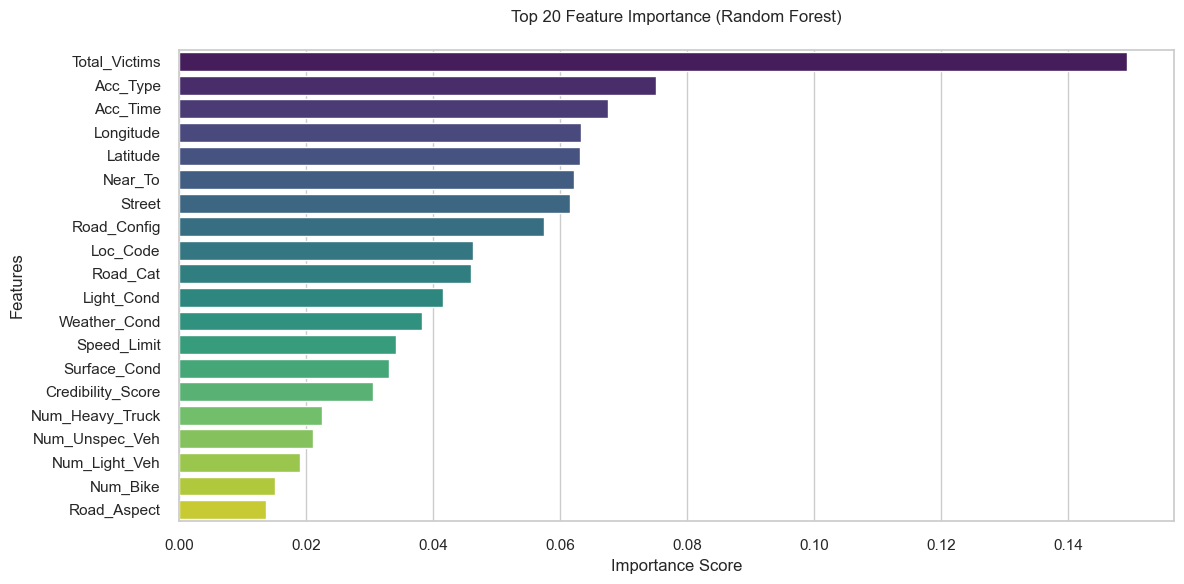


Top 20 Most Important Features (Random Forest):
          feature  importance
26  Total_Victims    0.149264
3        Acc_Type    0.075144
0        Acc_Time    0.067578
7       Longitude    0.063382
4        Latitude    0.063195
2         Near_To    0.062220
1          Street    0.061662
21    Road_Config    0.057436
6        Loc_Code    0.046319
20       Road_Cat    0.046072


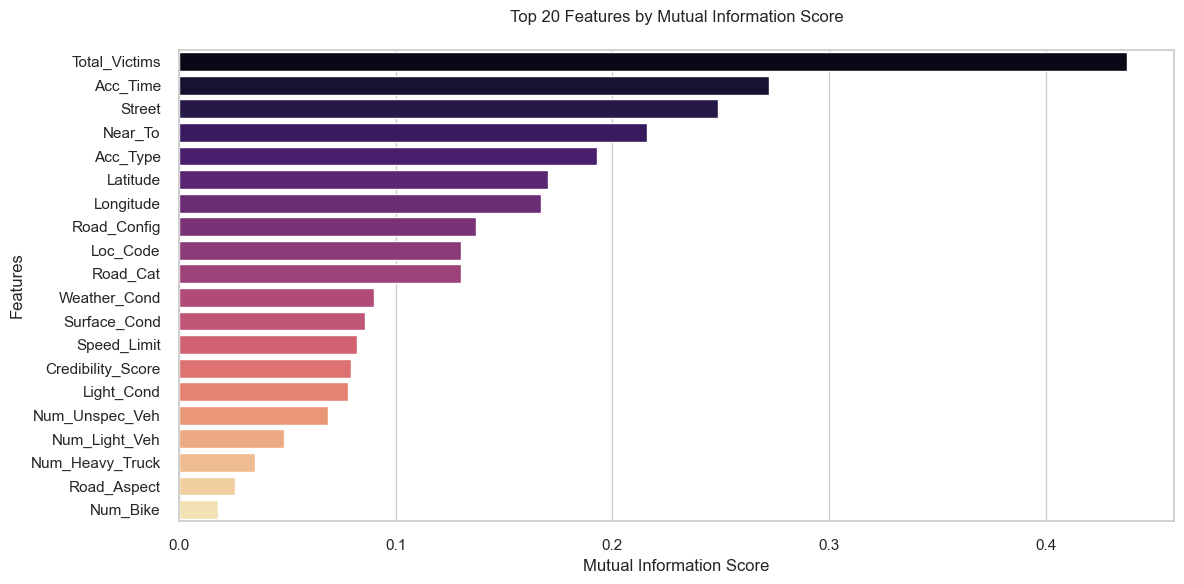


Top 20 Features by Mutual Information Score:
          feature  mi_score
26  Total_Victims  0.437311
0        Acc_Time  0.272383
1          Street  0.248802
2         Near_To  0.215913
3        Acc_Type  0.192774
4        Latitude  0.170489
7       Longitude  0.167139
21    Road_Config  0.137250
6        Loc_Code  0.130242
20       Road_Cat  0.130174


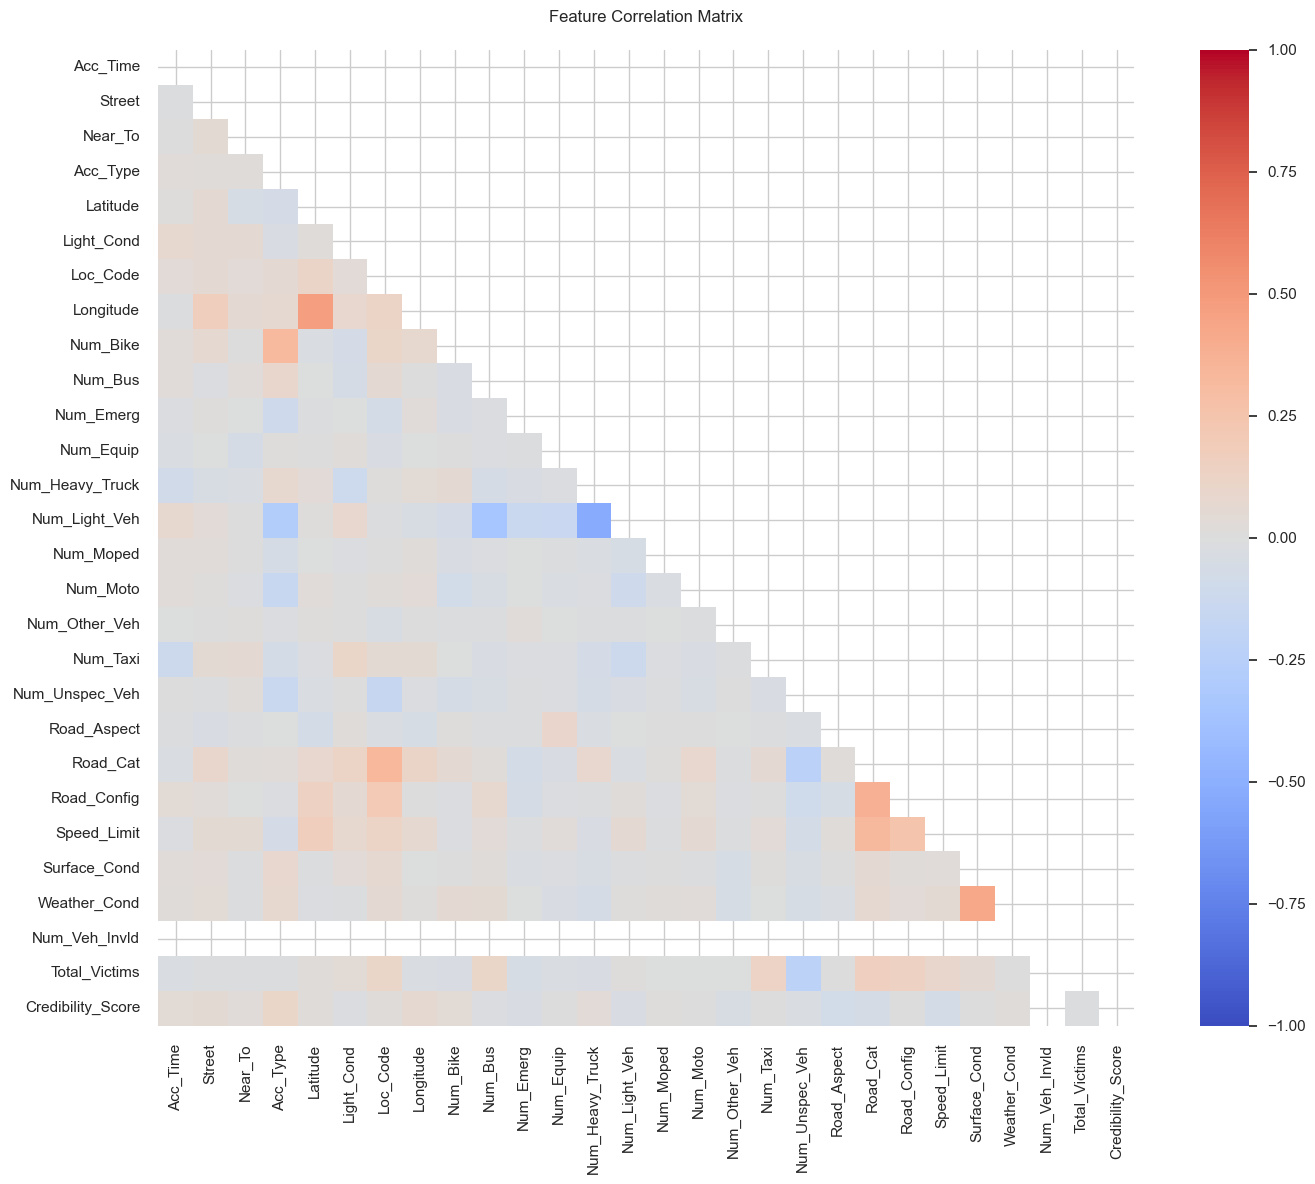

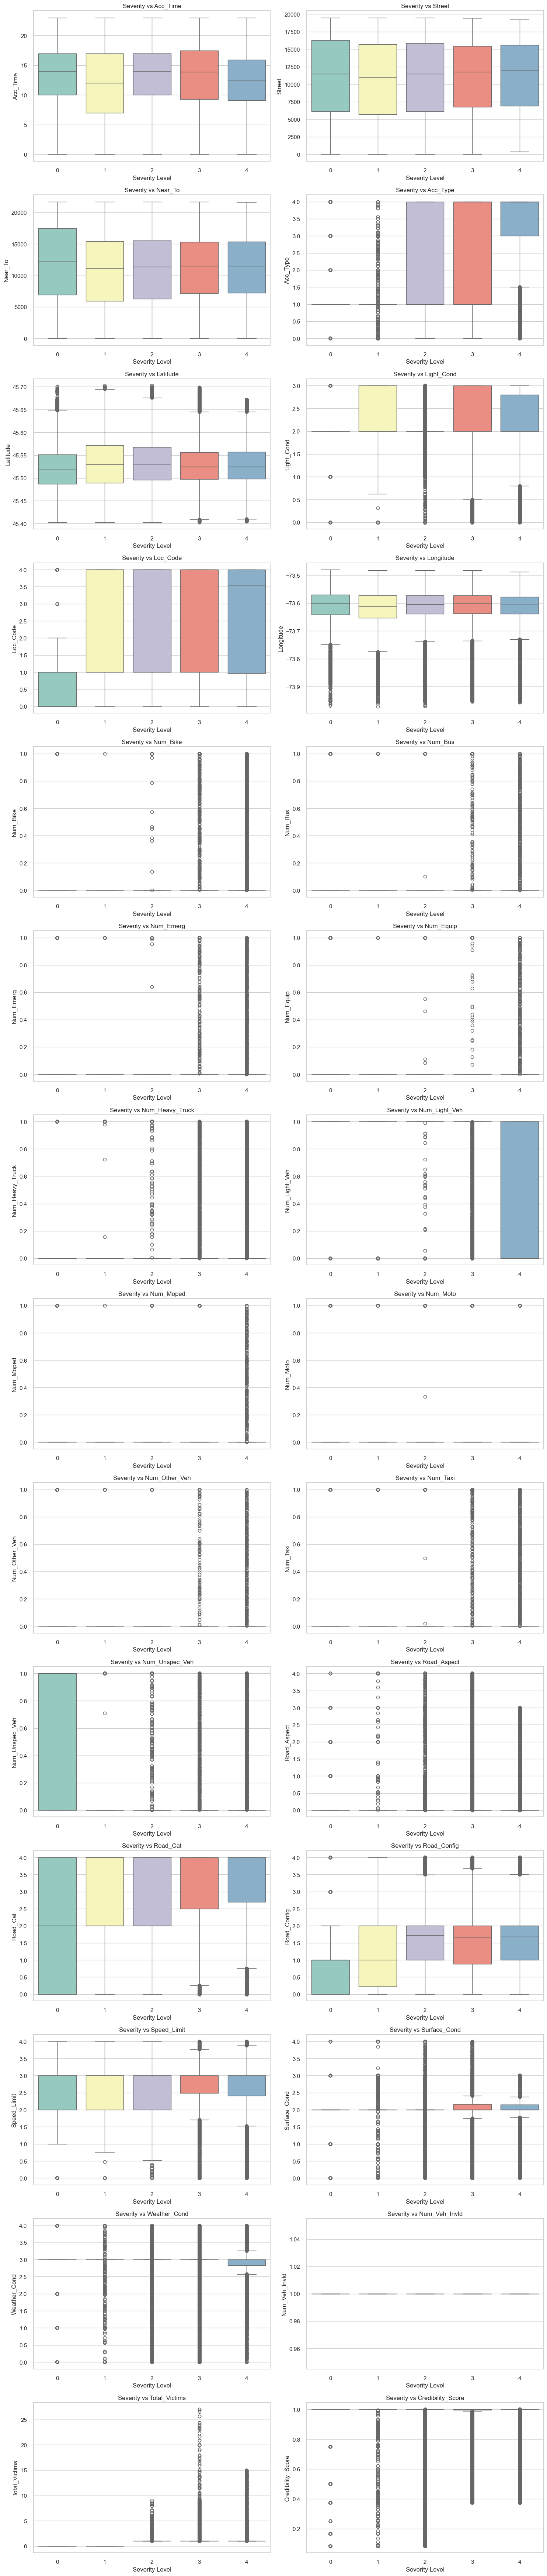


=== Summary Statistics for Numerical Features ===
        Acc_Time     Street    Near_To   Acc_Type   Latitude  Light_Cond  \
count  289942.00  289942.00  289942.00  289942.00  289942.00   289942.00   
mean       12.99   11023.62   11284.97       2.59      45.53        2.24   
std         5.46    5099.96    5462.33       1.46       0.05        0.53   
min         0.00       0.00       1.00       0.00      45.40        0.00   
25%         9.29    6417.56    6859.00       1.00      45.50        2.00   
50%        13.35   11690.37   11493.26       3.40      45.53        2.00   
75%        17.00   15662.55   15509.73       4.00      45.56        2.98   
max        23.00   19478.00   21718.00       4.00      45.70        3.00   

        Loc_Code  Longitude   Num_Bike    Num_Bus  ...  Road_Aspect  \
count  289942.00  289942.00  289942.00  289942.00  ...    289942.00   
mean        2.55     -73.62       0.12       0.04  ...         0.12   
std         1.69       0.07       0.32       0.20  

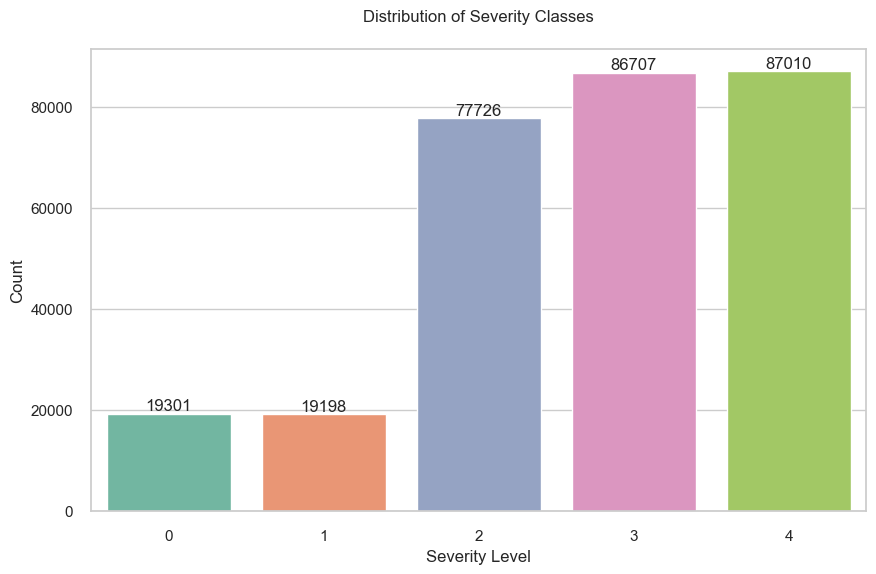


=== Severity Class Distribution ===
Severity
0    19301
1    19198
2    77726
3    86707
4    87010
Name: count, dtype: int64

=== Feature Value Distributions ===


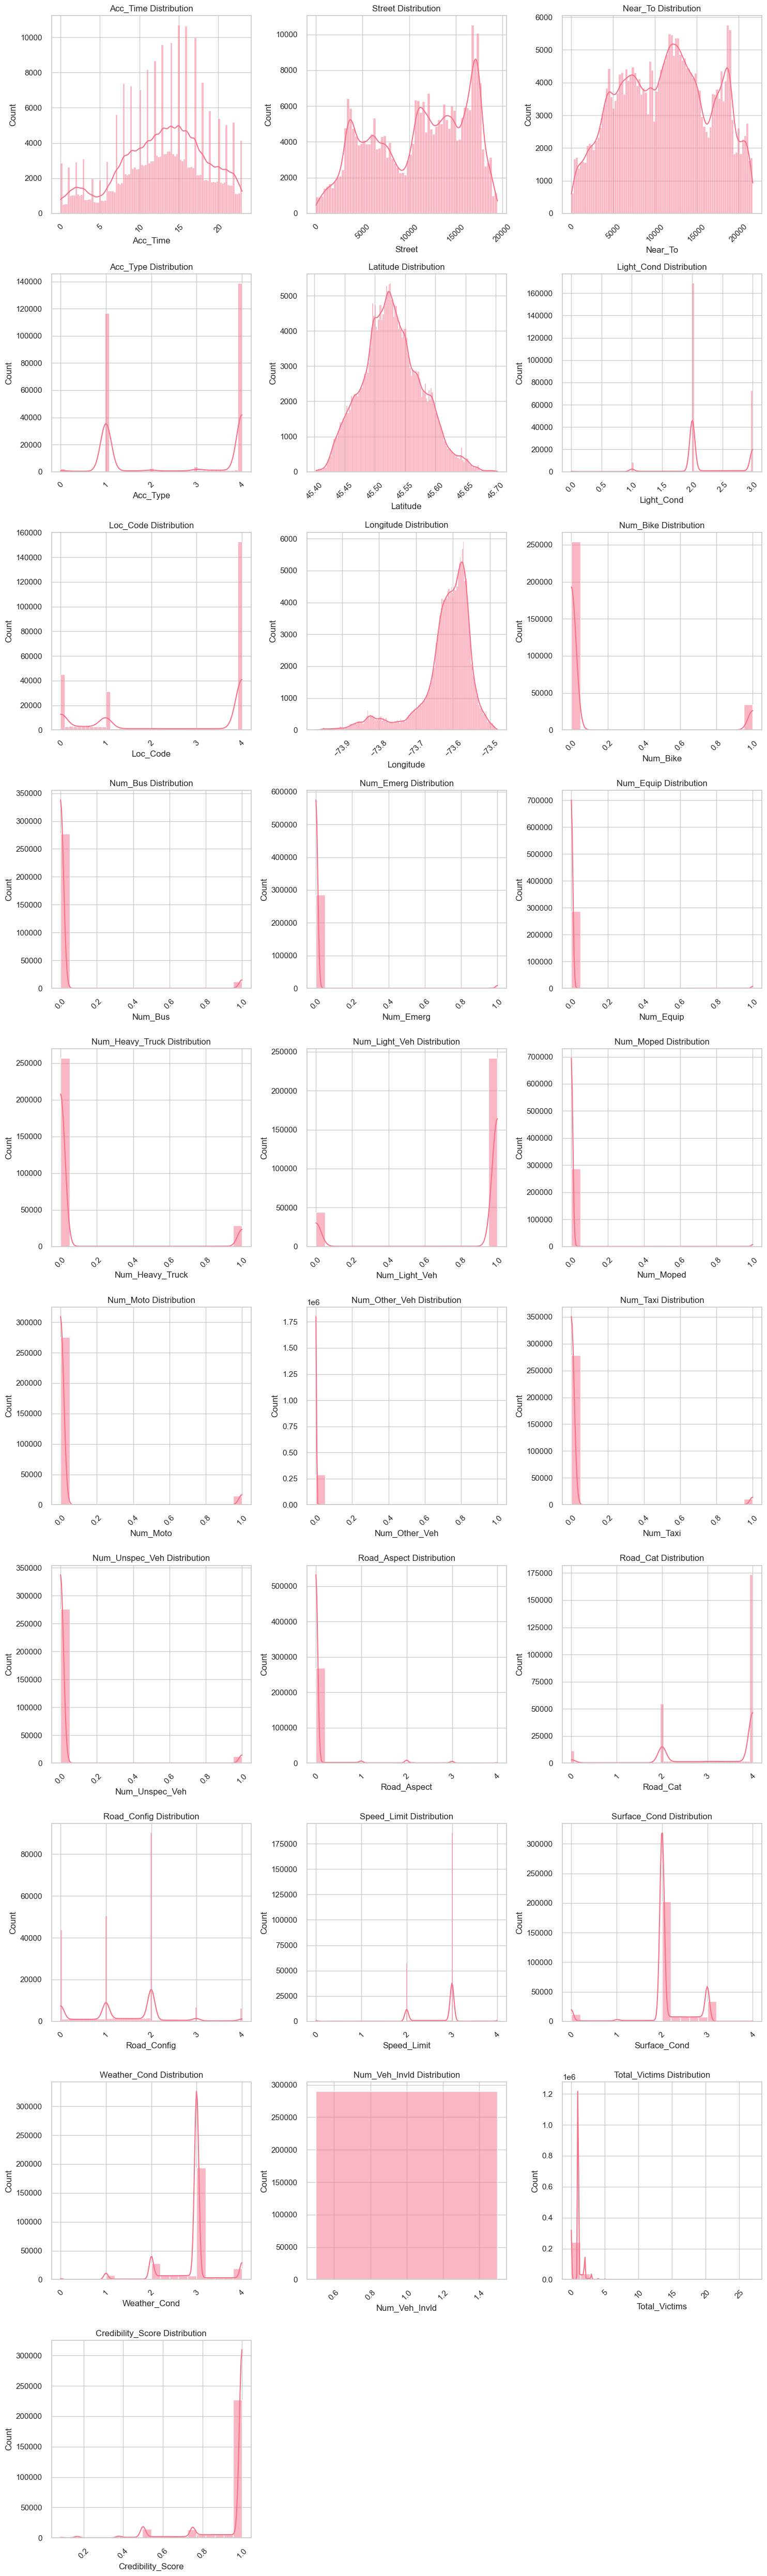


=== Analysis Complete ===
Total features analyzed: 28
Number of samples: 289942
Number of numerical features: 28
Number of categorical features: 0


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')  # Updated style name
sns.set_theme(style="whitegrid")  # More modern way to set style
sns.set_palette("husl")

# Load the SMOTE-ENN balanced dataset
print("Loading and preparing data...")
df = pd.read_csv('C:/Users/fairt/OneDrive/Desktop/smote_enn_data.csv')

# 1. Basic Dataset Information
print("\n=== Dataset Overview ===")
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# 2. Feature Importance using Random Forest
print("\n=== Computing Feature Importance ===")
X = df.drop('Severity', axis=1)
y = df['Severity']

# Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature', palette='viridis')
plt.title('Top 20 Feature Importance (Random Forest)', pad=20)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nTop 20 Most Important Features (Random Forest):")
print(feature_importance.head(10))

# 3. Mutual Information Score with Enhanced Visualization
mi_scores = mutual_info_classif(X, y)
mi_scores_df = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=mi_scores_df.head(20), x='mi_score', y='feature', palette='magma')
plt.title('Top 20 Features by Mutual Information Score', pad=20)
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nTop 20 Features by Mutual Information Score:")
print(mi_scores_df.head(10))

# 4. Enhanced Correlation Analysis
plt.figure(figsize=(15, 12))
correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            cmap='coolwarm',
            center=0,
            annot=False,
            fmt='.2f',
            square=True,
            vmin=-1,
            vmax=1)
plt.title('Feature Correlation Matrix', pad=20)
plt.tight_layout()
plt.show()

# 5. Feature-Target Relationship with Enhanced Visualization
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
n_features = len(numerical_features)
n_cols = 2
n_rows = (n_features + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes = np.array([axes])  # Ensure axes is 2D
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.boxplot(data=df, x='Severity', y=feature, ax=axes[idx], palette='Set3')
    axes[idx].set_title(f'Severity vs {feature}')
    axes[idx].set_xlabel('Severity Level')
    
# Hide empty subplots if any
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)
    
plt.tight_layout()
plt.show()

# 6. Enhanced Summary Statistics
print("\n=== Summary Statistics for Numerical Features ===")
print(df.describe().round(2))

# 7. Identify and Visualize Highly Correlated Features
high_corr_pairs = []
corr_threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            high_corr_pairs.append(
                (correlation_matrix.columns[i], 
                 correlation_matrix.columns[j], 
                 correlation_matrix.iloc[i, j]))

print("\n=== Highly Correlated Feature Pairs (correlation > 0.8) ===")
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
else:
    print("No feature pairs with correlation > 0.8 found")

# 8. Enhanced Class Distribution Visualization
plt.figure(figsize=(10, 6))
severity_counts = df['Severity'].value_counts().sort_index()
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette='Set2')
plt.title('Distribution of Severity Classes', pad=20)
plt.xlabel('Severity Level')
plt.ylabel('Count')

# Add value labels on top of each bar
for i, v in enumerate(severity_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

print("\n=== Severity Class Distribution ===")
print(severity_counts)

# 9. Additional Analysis: Feature Value Distributions
print("\n=== Feature Value Distributions ===")
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
n_features = len(numerical_features)
n_cols = 3
n_rows = (n_features + 2) // 3

plt.figure(figsize=(15, 5*n_rows))
for idx, feature in enumerate(numerical_features, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(data=df, x=feature, kde=True)
    plt.title(f'{feature} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print execution summary
print("\n=== Analysis Complete ===")
print(f"Total features analyzed: {len(X.columns)}")
print(f"Number of samples: {len(df)}")
print(f"Number of numerical features: {len(numerical_features)}")
print(f"Number of categorical features: {len(X.columns) - len(numerical_features)}")

## 1. Data Quality & Shape

* **No missing values** across all 29 columns—great, we can move straight to modeling.
* **Size**: 289 942 rows × 29 features (28 predictors + the target `Severity`).

## 2. Class Balance (Severity)

| Severity Level |  Count | % of Total |
| :------------: | :----: | :--------: |
|   0 (“Below”)  | 19 301 |    6.7 %   |
|   1 (“Minor”)  | 19 198 |    6.6 %   |
| 2 (“Moderate”) | 77 726 |   26.8 %   |
|  3 (“Serious”) | 86 707 |   29.9 %   |
|   4 (“Fatal”)  | 87 010 |   30.1 %   |

* **Takeaway**: Whereas classes 3–4 were virtually absent before, they now each account for \~30 % of cases. Classes 0–1 remain underrepresented (≈6–7 % each), so a mild imbalance persists (ratio ≈4.6 :1 between largest and smallest classes).

## 3. Top Predictors

Both **Random Forest importance** and **Mutual Information** rank the same handful of features at the top:

| Rank | Feature                                                    | RF Importance | MI Score |
| :--: | :--------------------------------------------------------- | :-----------: | :------: |
|   1  | Total\_Victims                                             |     0.149     |   0.437  |
|   2  | Acc\_Time                                                  |     0.068     |   0.272  |
|   3  | Street                                                     |     0.062     |   0.249  |
|   4  | Near\_To                                                   |     0.062     |   0.216  |
|   5  | Acc\_Type                                                  |     0.075     |   0.193  |
|   …  | Latitude, Longitude, Road\_Config, Loc\_Code, Road\_Cat, … |               |          |

* **Total\_Victims** is by far the strongest predictor.
* **Spatio-temporal cues** (time of day, street segment, nearby landmark, lat/long) carry substantial signal.
* **Road attributes** (type, configuration, category, location code) also rank highly.
  
## 4. Feature Distributions & Scalability

* **Acc\_Time** hovers around midday (mean ≈13:00, σ≈5 hrs)—accidents cluster in rush hours.
* **Street** and **Near\_To** are high-cardinality codes (0–19 478 & 1–21 718)—you’ll need an encoding strategy (e.g. target- or frequency encoding) rather than one-hot.
* **Vehicle-count features** (`Num_Bike`, `Num_Bus`, etc.) are almost all zeros with a handful of ones (very sparse).
* **Credibility\_Score** is essentially constant at 1.0 (75 %ile =1.0), so it may carry little discriminative power.

## 5. Correlation Structure

* **No pairs exceed |0.8|** correlation.
* The strongest moderate link is between **Longitude** & **Near\_To** (makes sense: certain landmarks lie in particular longitudes).
* **Vehicle counts** are mutually independent; you won’t need to worry about multicollinearity among them.

## 6. Summary of Key Insights & Next Steps

1. **Keep** the top 5–10 features identified by RF/MI as your core predictors.
2. **Drop or de-emphasize**:

   * `Num_Veh_Invld` (constant at 1.0),
   * `Credibility_Score` (near-constant),
   * any ultra-sparse vehicle counts unless you have a strong reason to include them.
3. **Encoding strategy** for `Street`/`Near_To`: target/frequency encoding or embedding.
4. **Discretize** or bin `Acc_Time` (e.g. rush-hour vs. off-peak) to capture nonlinear effects.
5. **Monitor** model performance on classes 0–1—consider class-weights or a milder resampling (SMOTETomek) if minority recall still lags.

#### Severity Classification

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/fairt/OneDrive/Desktop/smote_enn_data.csv')

# Constants
RANDOM_STATE = 42

# Define specific features
SELECTED_FEATURES = [
    'Longitude', 'Near_To', 'Street', 
    'Num_Unspec_Veh', 'Num_Emerg',
    'Surface_Cond', 'Light_Cond',  'Road_Config', 
    'Num_Taxi','Num_Heavy_Truck', 'Num_Moto', 'Num_Bike',
    'Num_Veh_Invld', 'Acc_Type',
    'Acc_Time', 'Speed_Limit', 'Environ_Type','Weather_Cond'
]

CATEGORICAL_FEATURES = [
    'Near_To', 'Street', 'Acc_Type',
    'Surface_Cond', 'Light_Cond', 'Road_Cat',
    'Road_Config', 'Weather_Cond', 'Num_Unspec_Veh',
    'Num_Emerg', 'Num_Taxi', 'Num_Heavy_Truck',
    'Num_Moto', 'Num_Bike', 'Num_Veh_Invld'
]


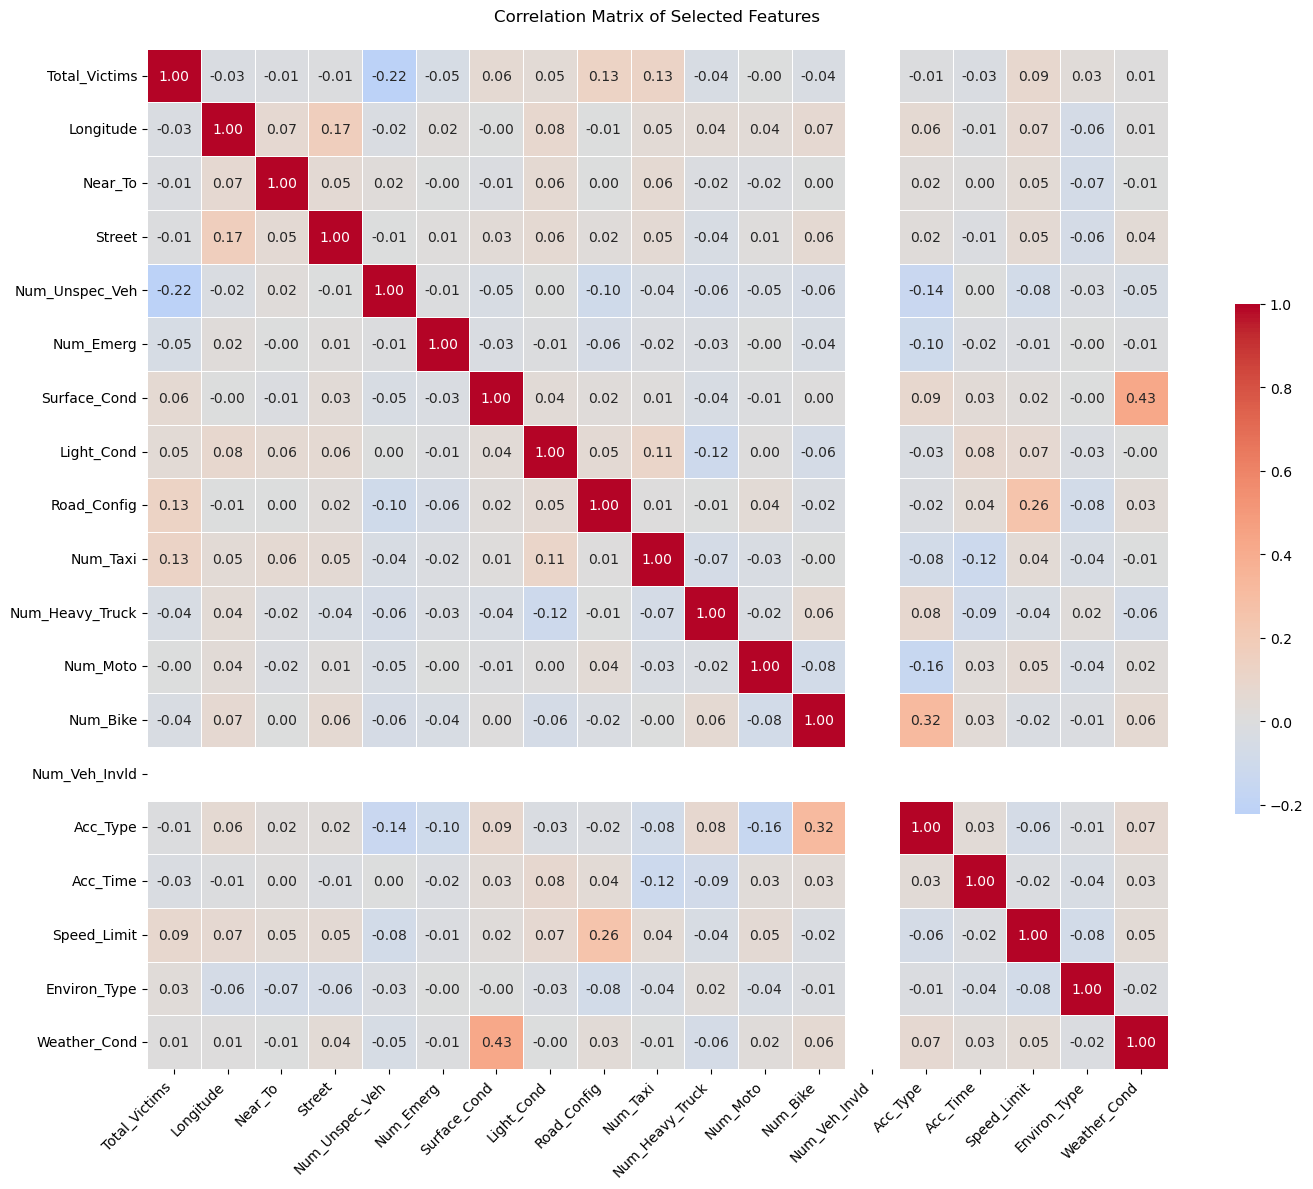


Strong Correlations (|correlation| > 0.5):


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a DataFrame called 'df'
SELECTED_FEATURES = [
    'Total_Victims', 'Longitude', 'Near_To', 'Street',
    'Num_Unspec_Veh', 'Num_Emerg',
    'Surface_Cond', 'Light_Cond', 'Road_Config',
    'Num_Taxi', 'Num_Heavy_Truck', 'Num_Moto', 'Num_Bike',
    'Num_Veh_Invld', 'Acc_Type',
    'Acc_Time', 'Speed_Limit', 'Environ_Type','Weather_Cond'
]

# Calculate correlation matrix
correlation_matrix = df[SELECTED_FEATURES].corr()

# Create a figure
plt.figure(figsize=(15, 12))

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format correlation values to 2 decimal places
            square=True,  # Make cells square
            linewidths=0.5,  # Add lines between cells
            cbar_kws={"shrink": .5})  # Adjust colorbar size

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add title
plt.title('Correlation Matrix of Selected Features', pad=20)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print strong correlations (absolute value > 0.5)
strong_correlations = []
for i in range(len(SELECTED_FEATURES)):
    for j in range(i+1, len(SELECTED_FEATURES)):
        corr = correlation_matrix.iloc[i,j]
        if abs(corr) > 0.5:
            strong_correlations.append({
                'Feature 1': SELECTED_FEATURES[i],
                'Feature 2': SELECTED_FEATURES[j],
                'Correlation': corr
            })

# Print strong correlations
print("\nStrong Correlations (|correlation| > 0.5):")
for corr in sorted(strong_correlations, key=lambda x: abs(x['Correlation']), reverse=True):
    print(f"{corr['Feature 1']} - {corr['Feature 2']}: {corr['Correlation']:.3f}")

No severe multi-collinearity issue. The data is ready to be trained.

Dataset size: 289604

Class distribution:
Severity
0    19370
1    18988
2    77401
3    86832
4    87013
Name: count, dtype: int64

Training set size: 231683
Test set size: 57921

Training Random Forest...

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.56      0.67      3874
           1       0.66      0.23      0.34      3798
           2       0.72      0.85      0.78     15480
           3       0.90      0.93      0.92     17366
           4       0.96      0.99      0.98     17403

    accuracy                           0.86     57921
   macro avg       0.82      0.71      0.74     57921
weighted avg       0.85      0.86      0.84     57921



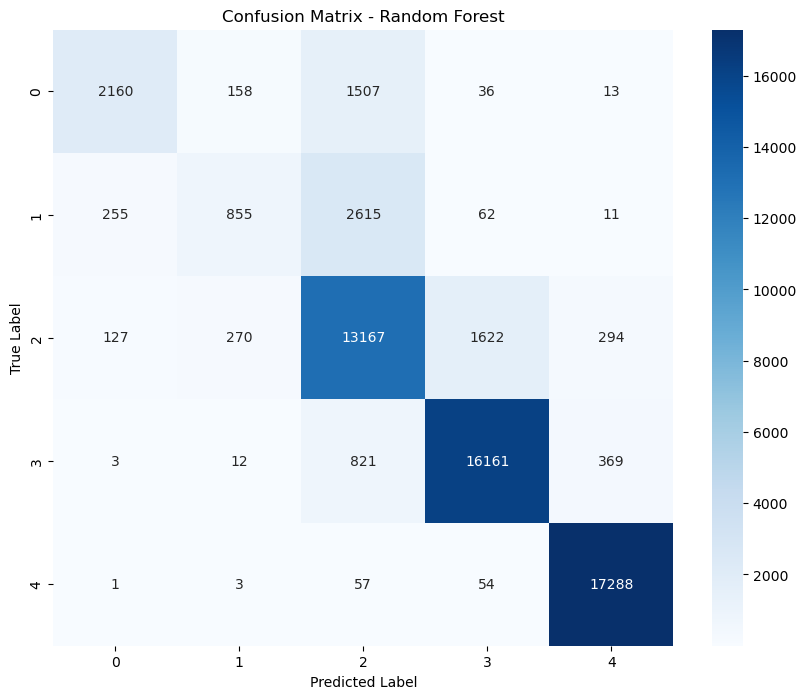


Training XGBoost...

Results for XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71      3874
           1       0.54      0.40      0.46      3798
           2       0.81      0.86      0.83     15480
           3       0.95      0.98      0.97     17366
           4       0.99      1.00      1.00     17403

    accuracy                           0.89     57921
   macro avg       0.81      0.78      0.79     57921
weighted avg       0.89      0.89      0.89     57921



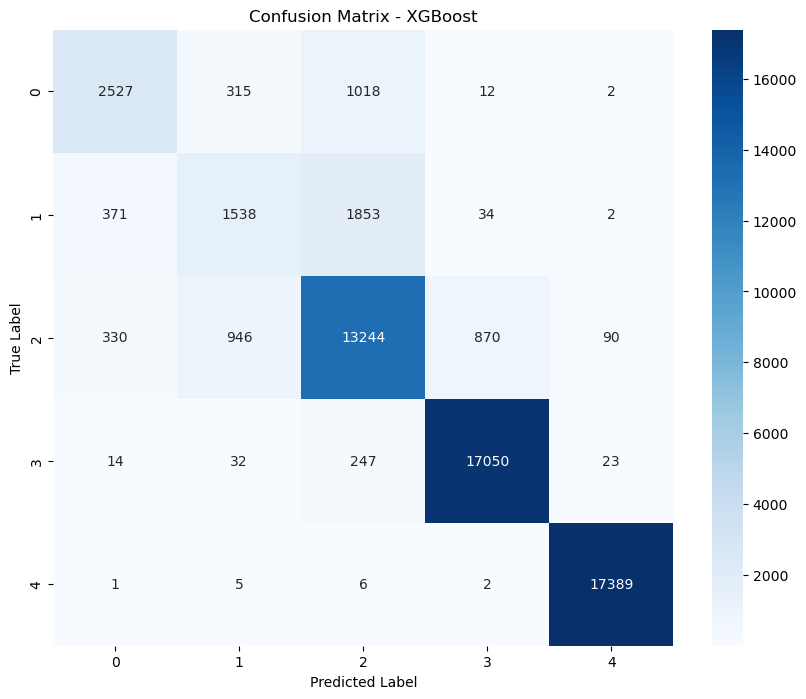


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4081
[LightGBM] [Info] Number of data points in the train set: 231683, number of used features: 17
[LightGBM] [Info] Start training from score -2.704788
[LightGBM] [Info] Start training from score -2.724733
[LightGBM] [Info] Start training from score -1.319511
[LightGBM] [Info] Start training from score -1.204533
[LightGBM] [Info] Start training from score -1.202462

Results for LightGBM:
              precision    recall  f1-score   support

           0       0.79      0.65      0.71      3874
           1       0.58      0.35      0.44      3798
           2       0.76      0.82      0.79     15480
           3       0.91      0.94      0.93     17366
           4       0.98      1.00      0.99     17403

    a

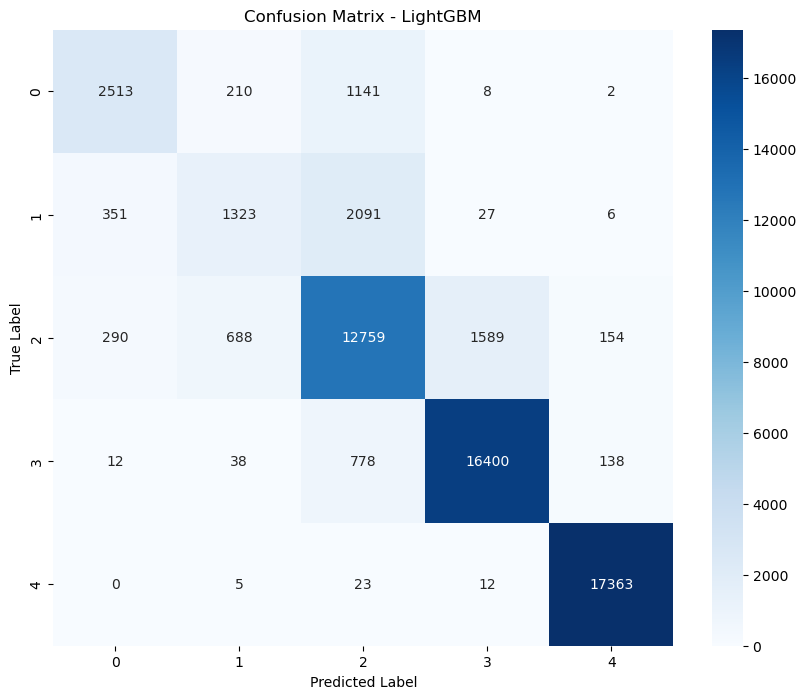

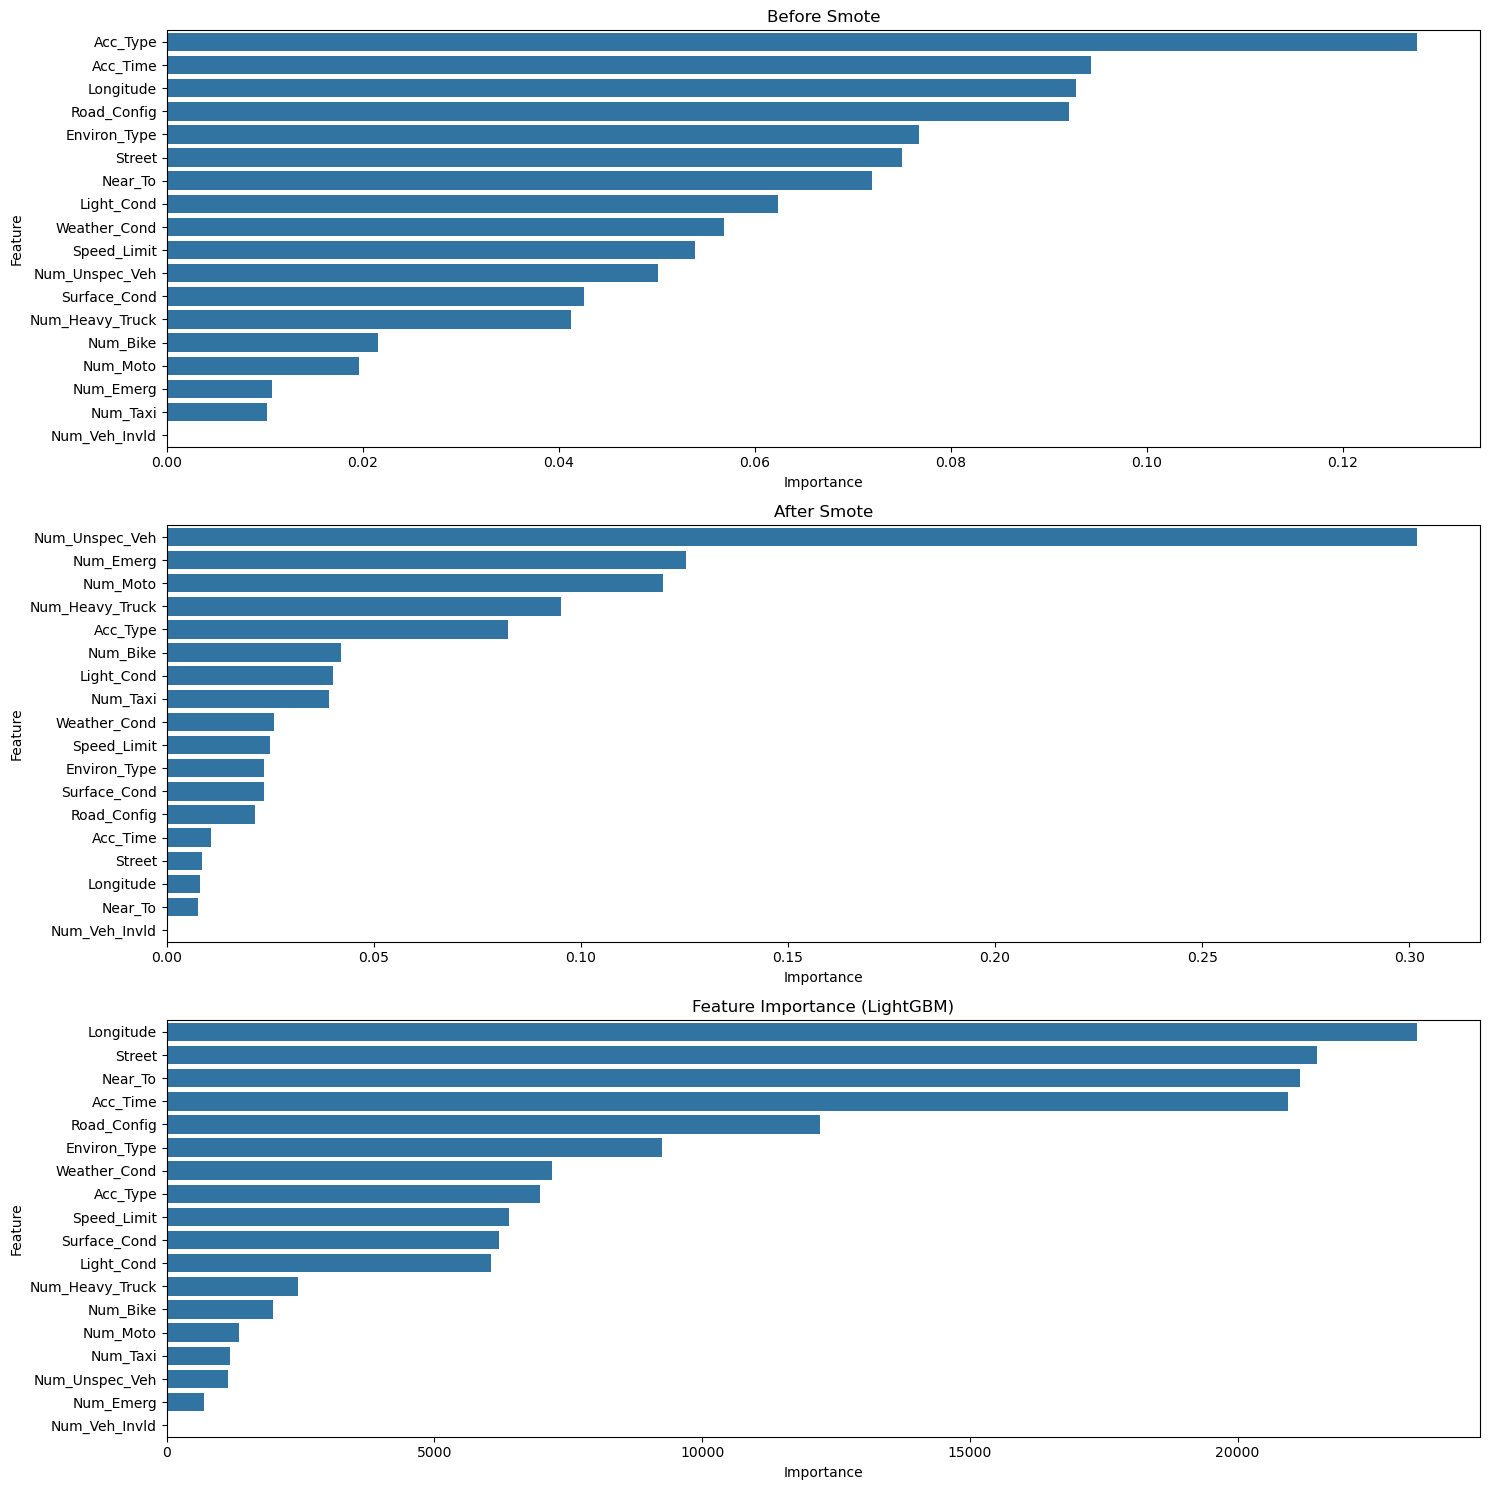


Top 10 Most Important Features Comparison:

Random Forest Top 10:
         Feature  RF_Importance
13      Acc_Type       0.127628
14      Acc_Time       0.094302
0      Longitude       0.092756
7    Road_Config       0.092109
16  Environ_Type       0.076774
2         Street       0.075063
1        Near_To       0.071981
6     Light_Cond       0.062326
17  Weather_Cond       0.056872
15   Speed_Limit       0.053942

XGBoost Top 10:
            Feature  XGB_Importance
3    Num_Unspec_Veh        0.301981
4         Num_Emerg        0.125409
10         Num_Moto        0.119871
9   Num_Heavy_Truck        0.095096
13         Acc_Type        0.082332
11         Num_Bike        0.042101
6        Light_Cond        0.040221
8          Num_Taxi        0.039181
17     Weather_Cond        0.025839
15      Speed_Limit        0.025023

LightGBM Top 10:
         Feature  LGB_Importance
0      Longitude           23360
2         Street           21489
1        Near_To           21160
14      Acc_Time  

In [19]:
import lightgbm as lgb
# Load data and select features
X = df[SELECTED_FEATURES].copy()

# Handle categorical features
label_encoders = {}
for feature in CATEGORICAL_FEATURES:
    if feature in X.columns:
        label_encoders[feature] = LabelEncoder()
        X[feature] = label_encoders[feature].fit_transform(X[feature].astype(str))

# Prepare target variable
y = df['Severity'].copy()

# Print initial distribution
print("Dataset size:", len(X))
print("\nClass distribution:")
print(pd.Series(y).value_counts().sort_index())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nTraining set size:", len(X_train))
print("Test set size:", len(X_test))

# Initialize models
rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=20,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=RANDOM_STATE
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=1000,
    max_depth=20,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    random_state=RANDOM_STATE
)

# Train and evaluate models
models = {
    'Random Forest': rf,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model  # Replacing Gradient Boosting with LightGBM
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results[name] = {
        'predictions': y_pred,
        'report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    print(f"\nResults for {name}:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Feature Importance Analysis
plt.figure(figsize=(15, 15))

# Random Forest Feature Importance
plt.subplot(3, 1, 1)
rf_feature_imp = pd.DataFrame({
    'Feature': SELECTED_FEATURES,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=rf_feature_imp)
plt.title('Before Smote')
plt.tight_layout()

# XGBoost Feature Importance
plt.subplot(3, 1, 2)
xgb_feature_imp = pd.DataFrame({
    'Feature': SELECTED_FEATURES,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=xgb_feature_imp)
plt.title('After Smote')
plt.tight_layout()

# LightGBM Feature Importance
plt.subplot(3, 1, 3)
lgb_feature_imp = pd.DataFrame({
    'Feature': SELECTED_FEATURES,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=lgb_feature_imp)
plt.title('Feature Importance (LightGBM)')
plt.tight_layout()

plt.show()

# Print feature importance comparison
print("\nTop 10 Most Important Features Comparison:")
comparison_df = pd.DataFrame({
    'Feature': SELECTED_FEATURES,
    'RF_Importance': rf.feature_importances_,
    'XGB_Importance': xgb_model.feature_importances_,
    'LGB_Importance': lgb_model.feature_importances_
})

# Sort by average importance
comparison_df['Avg_Importance'] = comparison_df[['RF_Importance', 'XGB_Importance', 'LGB_Importance']].mean(axis=1)
comparison_df = comparison_df.sort_values('Avg_Importance', ascending=False)

print("\nRandom Forest Top 10:")
print(comparison_df.nlargest(10, 'RF_Importance')[['Feature', 'RF_Importance']])

print("\nXGBoost Top 10:")
print(comparison_df.nlargest(10, 'XGB_Importance')[['Feature', 'XGB_Importance']])

print("\nLightGBM Top 10:")
print(comparison_df.nlargest(10, 'LGB_Importance')[['Feature', 'LGB_Importance']])


## 1. Overall Accuracy & Class-wise Recall

|       Model       | Accuracy | Recall (0) | Recall (1) | Recall (2) | Recall (3) | Recall (4) |
| :---------------: | :------: | :--------: | :--------: | :--------: | :--------: | :--------: |
| **Random Forest** |   0.86   |    0.56    |    0.23    |    0.85    |    0.93    |    0.99    |
|    **LightGBM**   |   0.87   |    0.65    |    0.35    |    0.82    |    0.94    |    1.00    |
|    **XGBoost**    | **0.89** |  **0.65**  |  **0.40**  |  **0.86**  |  **0.98**  |  **1.00**  |

* **XGBoost wins** on overall accuracy (0.89 vs. 0.86/0.87) and macro‐averaged recall, thanks largely to much better detection of the formerly under‐represented classes 0 (“below threshold”) and 1 (“minor”).
* All three do extremely well on the high-severity classes (3 & 4), with recalls ≥ 0.93 across the board.
* **Random Forest** still lags on classes 0–1 (especially class 1: recall 0.23), meaning it tends to overpredict the moderate-to-severe categories.

## 2. Confusion Patterns

| True → Predicted |        RF        |       XGB       |       LGBM       |
| :--------------: | :--------------: | :-------------: | :--------------: |
|    **Class 0**   |  2160 TP, 1507→2 | 2527 TP, 1018→2 |  2513 TP, 1141→2 |
|    **Class 1**   |  855 TP, 2615→2  | 1538 TP, 1853→2 |  1323 TP, 2091→2 |
|    **Class 2**   | 13167 TP, 1622→3 | 13244 TP, 870→3 | 12759 TP, 1589→3 |

* All models most often confuse the low-severity classes (0 & 1) with class 2 (“moderate”).
* **XGBoost** cuts the 0→2 and 1→2 misclassification rates nearly in half versus RF, helping boost its minority‐class recall.
* LightGBM sits in between.

## 3. Precision & F1 Highlights

|   Model  | Class 0 F1 | Class 1 F1 | Class 2 F1 | Macro F1 |
| :------: | :--------: | :--------: | :--------: | :------: |
|    RF    |    0.67    |    0.34    |    0.78    |   0.74   |
| LightGBM |    0.71    |    0.44    |    0.79    |   0.77   |
|  XGBoost |  **0.71**  |  **0.46**  |  **0.83**  | **0.79** |

* Again, XGBoost leads on F1 for all three lowest-severity classes, giving it the best balanced performance.

## 4. What Each Model Thinks Matters

| Rank | Random Forest                   | XGBoost                  | LightGBM                       |
| :--: | :------------------------------ | :----------------------- | :----------------------------- |
|   1  | Acc\_Type                       | Num\_Unspec\_Veh         | Longitude                      |
|   2  | Acc\_Time                       | Num\_Emerg               | Street                         |
|   3  | Longitude                       | Num\_Moto                | Near\_To                       |
|   4  | Road\_Config                    | Num\_Heavy\_Truck        | Acc\_Time                      |
|   5  | Environ\_Type                   | Acc\_Type                | Road\_Config                   |
|   …  | Street, Near\_To, Light\_Cond … | Num\_Bike, Light\_Cond … | Environ\_Type, Weather\_Cond … |

* **Random Forest** & **LightGBM** both lean heavily on the accident’s context (type, time, location, road configuration).
* **XGBoost**, by contrast, gives top billing to the **vehicle-count features** (Num\_Unspec\_Veh, Num\_Emerg, Num\_Moto, …) before falling back on Acc\_Type.
* All three agree that **Acc\_Type**, **Acc\_Time**, **Speed\_Limit** and **Weather\_Cond** carry real signal—but the boosted trees (XGB) find even more “gain” in those sparse count variables.

## 5. Small Conclusion (with some project scope recommendation)

1. **Best performer**: XGBoost—with its superior recall on the hardest classes and highest macro F1, it’s the go-to if you need a single model.
2. **Trade-off**: RF is simplest to tune but struggles on classes 0–1; LightGBM is a nice middle ground.
3. **Feature engineering**:

   * If we want to align all models, consider grouping or binning those ultra-sparse vehicle counts so RF/LGBM can exploit them more.
   * Conversely, we could prune some count features (or regularize) if they feel too noisy—especially if interpretability is a priority.
4. **Class imbalance still matters**: Even after SMOTEENN, classes 0–1 remain under 7 % each. We may squeeze out another few points by class-weighting or a milder resampling strategy (e.g. SMOTETomek).

All told, XGBoost delivers the highest sensitivity to both rare and common severities, at the cost of a more complex feature-importance story. LightGBM strikes a solid balance, and RF remains a strong baseline if we’re comfortable sacrificing some minority-class recall.

#### Hyperparameter Tuning

Loading and preparing data...

Splitting data into train and test sets...
Training set size: 231953
Test set size: 57989

==================== Logistic Regression ====================
Training Time: 151.02 seconds

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'liblinear'}

Cross-validation Scores (on training data):
CV Accuracy: 0.5231 (+/- 0.0144)
CV F1-Score: 0.4731 (+/- 0.0206)

Test Set Performance:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3860
           1       0.80      0.85      0.82      3840
           2       0.51      0.54      0.53     15545
           3       0.36      0.08      0.13     17342
           4       0.45      0.78      0.57     17402

    accuracy                           0.51     57989
   macro avg       0.59      0.61      0.57     57989
weighted avg       0.49      0.51      0.46     57989



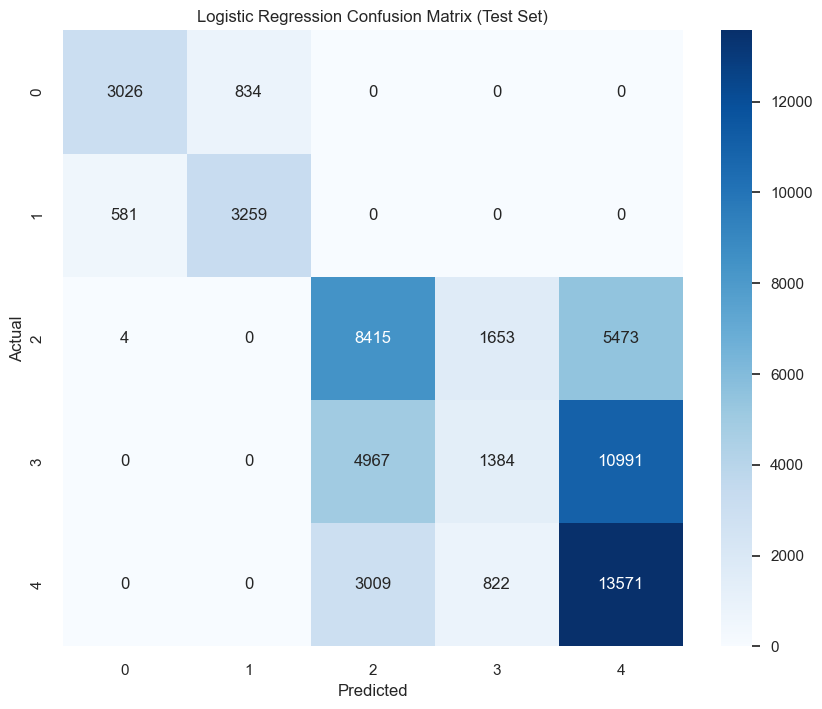


==================== Random Forest ====================


KeyboardInterrupt: 

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
from time import time
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

# Load data
print("Loading and preparing data...")
df = pd.read_csv('C:/Users/fairt/OneDrive/Desktop/smote_enn_data.csv')
X = df.drop('Severity', axis=1)
y = df['Severity']

# Split the data
print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# 1. Logistic Regression
print("\n" + "="*20 + " Logistic Regression " + "="*20)
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [1000],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced']
}

lr_start = time()
lr_grid = GridSearchCV(LogisticRegression(random_state=42),
                      lr_params,
                      cv=cv,
                      n_jobs=-1,
                      scoring='f1_weighted')
lr_grid.fit(X_train, y_train)
lr_time = time() - lr_start
lr_pred = lr_grid.predict(X_test)

# Cross-validation scores
lr_cv_accuracy = cross_val_score(lr_grid.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')
lr_cv_f1 = cross_val_score(lr_grid.best_estimator_, X_train, y_train, cv=cv, scoring='f1_weighted')

print(f"Training Time: {lr_time:.2f} seconds")
print("\nBest Parameters:", lr_grid.best_params_)
print("\nCross-validation Scores (on training data):")
print(f"CV Accuracy: {lr_cv_accuracy.mean():.4f} (+/- {lr_cv_accuracy.std() * 2:.4f})")
print(f"CV F1-Score: {lr_cv_f1.mean():.4f} (+/- {lr_cv_f1.std() * 2:.4f})")
print("\nTest Set Performance:")
print(classification_report(y_test, lr_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

results['Logistic Regression'] = {
    'model': lr_grid,
    'predictions': lr_pred,
    'time': lr_time,
    'test_accuracy': accuracy_score(y_test, lr_pred),
    'test_f1': f1_score(y_test, lr_pred, average='weighted'),
    'cv_accuracy': lr_cv_accuracy.mean(),
    'cv_f1': lr_cv_f1.mean()
}

# 2. Random Forest
print("\n" + "="*20 + " Random Forest " + "="*20)
rf_params = {
    'n_estimators': [100, 200],  # Reduced from [100, 200, 300]
    'max_depth': [10, 15],       # Reduced from [5, 10, 15, 20]
    'min_samples_split': [5, 10],  # Removed value 2
    'min_samples_leaf': [2, 4],    # Removed value 1
    'max_features': ['sqrt'],      # Only using sqrt instead of both sqrt and log2
    'class_weight': ['balanced']   # Only using balanced instead of both options
}

rf_start = time()
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),  # Added n_jobs=-1 to RF itself
                      rf_params,
                      cv=3,        # Reduced from 5 to 3
                      n_jobs=-1,
                      scoring='f1_weighted',
                      verbose=1)   # Added verbose to see progress
rf_grid.fit(X_train, y_train)
rf_time = time() - rf_start
rf_pred = rf_grid.predict(X_test)

# Cross-validation scores
rf_cv_accuracy = cross_val_score(rf_grid.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')
rf_cv_f1 = cross_val_score(rf_grid.best_estimator_, X_train, y_train, cv=cv, scoring='f1_weighted')

print(f"Training Time: {rf_time:.2f} seconds")
print("\nBest Parameters:", rf_grid.best_params_)
print("\nCross-validation Scores (on training data):")
print(f"CV Accuracy: {rf_cv_accuracy.mean():.4f} (+/- {rf_cv_accuracy.std() * 2:.4f})")
print(f"CV F1-Score: {rf_cv_f1.mean():.4f} (+/- {rf_cv_f1.std() * 2:.4f})")
print("\nTest Set Performance:")
print(classification_report(y_test, rf_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

results['Random Forest'] = {
    'model': rf_grid,
    'predictions': rf_pred,
    'time': rf_time,
    'test_accuracy': accuracy_score(y_test, rf_pred),
    'test_f1': f1_score(y_test, rf_pred, average='weighted'),
    'cv_accuracy': rf_cv_accuracy.mean(),
    'cv_f1': rf_cv_f1.mean()
}

# 3. XGBoost
print("\n" + "="*20 + " XGBoost " + "="*20)
xgb_params = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

xgb_start = time()
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False),
                       xgb_params,
                       cv=cv,
                       n_jobs=-1,
                       scoring='f1_weighted')
xgb_grid.fit(X_train, y_train)
xgb_time = time() - xgb_start
xgb_pred = xgb_grid.predict(X_test)

# Cross-validation scores
xgb_cv_accuracy = cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')
xgb_cv_f1 = cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv=cv, scoring='f1_weighted')

print(f"Training Time: {xgb_time:.2f} seconds")
print("\nBest Parameters:", xgb_grid.best_params_)
print("\nCross-validation Scores (on training data):")
print(f"CV Accuracy: {xgb_cv_accuracy.mean():.4f} (+/- {xgb_cv_accuracy.std() * 2:.4f})")
print(f"CV F1-Score: {xgb_cv_f1.mean():.4f} (+/- {xgb_cv_f1.std() * 2:.4f})")
print("\nTest Set Performance:")
print(classification_report(y_test, xgb_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

results['XGBoost'] = {
    'model': xgb_grid,
    'predictions': xgb_pred,
    'time': xgb_time,
    'test_accuracy': accuracy_score(y_test, xgb_pred),
    'test_f1': f1_score(y_test, xgb_pred, average='weighted'),
    'cv_accuracy': xgb_cv_accuracy.mean(),
    'cv_f1': xgb_cv_f1.mean()
}

# 4. LightGBM
print("\n" + "="*20 + " LightGBM " + "="*20)
lgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [4, 6, 8],
    'min_child_samples': [20, 50],
    'subsample': [0.8, 1.0]
}

lgb_start = time()
lgb_grid = GridSearchCV(lgb.LGBMClassifier(random_state=42),
                       lgb_params,
                       cv=cv,
                       n_jobs=-1,
                       scoring='f1_weighted')
lgb_grid.fit(X_train, y_train)
lgb_time = time() - lgb_start
lgb_pred = lgb_grid.predict(X_test)

# Cross-validation scores
lgb_cv_accuracy = cross_val_score(lgb_grid.best_estimator_, X_train, y_train, cv=cv, scoring='accuracy')
lgb_cv_f1 = cross_val_score(lgb_grid.best_estimator_, X_train, y_train, cv=cv, scoring='f1_weighted')

print(f"Training Time: {lgb_time:.2f} seconds")
print("\nBest Parameters:", lgb_grid.best_params_)
print("\nCross-validation Scores (on training data):")
print(f"CV Accuracy: {lgb_cv_accuracy.mean():.4f} (+/- {lgb_cv_accuracy.std() * 2:.4f})")
print(f"CV F1-Score: {lgb_cv_f1.mean():.4f} (+/- {lgb_cv_f1.std() * 2:.4f})")
print("\nTest Set Performance:")
print(classification_report(y_test, lgb_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, lgb_pred), annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

results['LightGBM'] = {
    'model': lgb_grid,
    'predictions': lgb_pred,
    'time': lgb_time,
    'test_accuracy': accuracy_score(y_test, lgb_pred),
    'test_f1': f1_score(y_test, lgb_pred, average='weighted'),
    'cv_accuracy': lgb_cv_accuracy.mean(),
    'cv_f1': lgb_cv_f1.mean()
}

# Final Comparison
print("\n" + "="*20 + " Final Model Comparison " + "="*20)
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Training Time (s)': [results[model]['time'] for model in results],
    'Test Accuracy': [results[model]['test_accuracy'] for model in results],
    'CV Accuracy': [results[model]['cv_accuracy'] for model in results],
    'Test F1 Score': [results[model]['test_f1'] for model in results],
    'CV F1 Score': [results[model]['cv_f1'] for model in results]
})

print("\nModel Performance Comparison:")
print(comparison_df.round(4).to_string(index=False))

# Final visualizations
plt.figure(figsize=(15, 6))
metrics = ['Test Accuracy', 'CV Accuracy', 'Test F1 Score', 'CV F1 Score']
x = np.arange(len(results))
width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, comparison_df[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Final Model Performance Comparison')
plt.xticks(x + width*1.5, comparison_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Training time comparison
plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Model'], comparison_df['Training Time (s)'])
plt.title('Model Training Time Comparison')
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()